<a href="https://colab.research.google.com/github/cnboonhan/colab/blob/main/sd_generate_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys, os, distutils.core

! pip install --upgrade \
  diffusers~=0.16 \
  transformers~=4.28 \
  opencv-python \
  pyyaml==5.1

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

OUTPUT_IMAGE_DIMS_X = 512
OUTPUT_IMAGE_DIMS_Y = 512

def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

pipeline = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
pipeline = pipeline.to("cuda")

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

  Using cached opencv_python-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.7 MB)
  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


[12/26 07:02:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:00, 254MB/s]                           


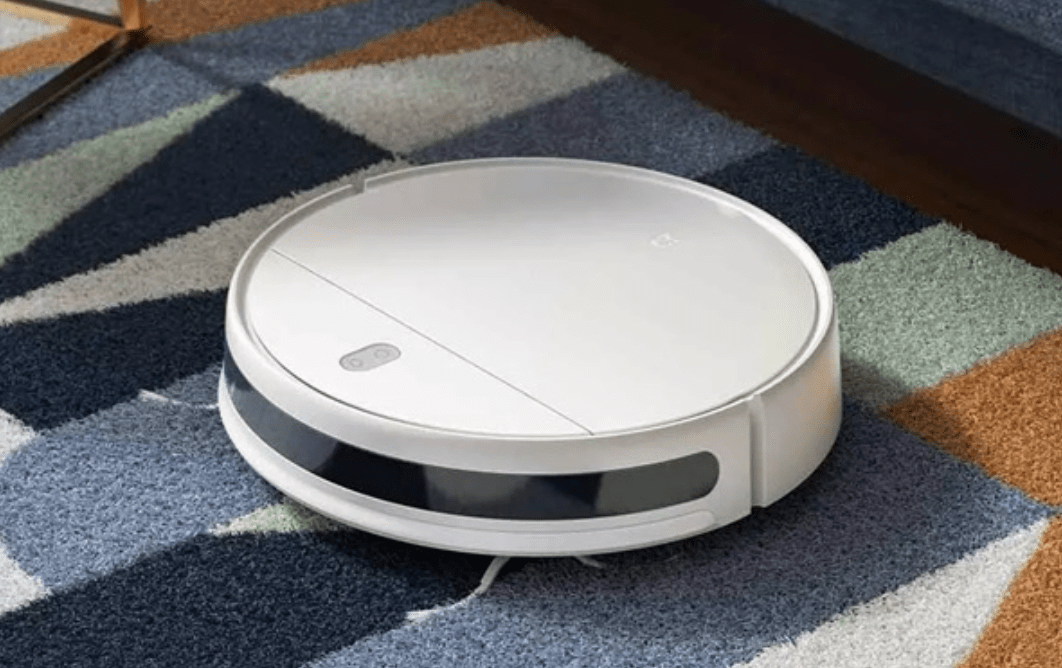

In [ ]:
# Get base image
!wget https://thesmartlocal.com/wp-content/uploads/2020/06/Robotic-Vacuum-Cleaners-in-Singapore-8.png -q -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)

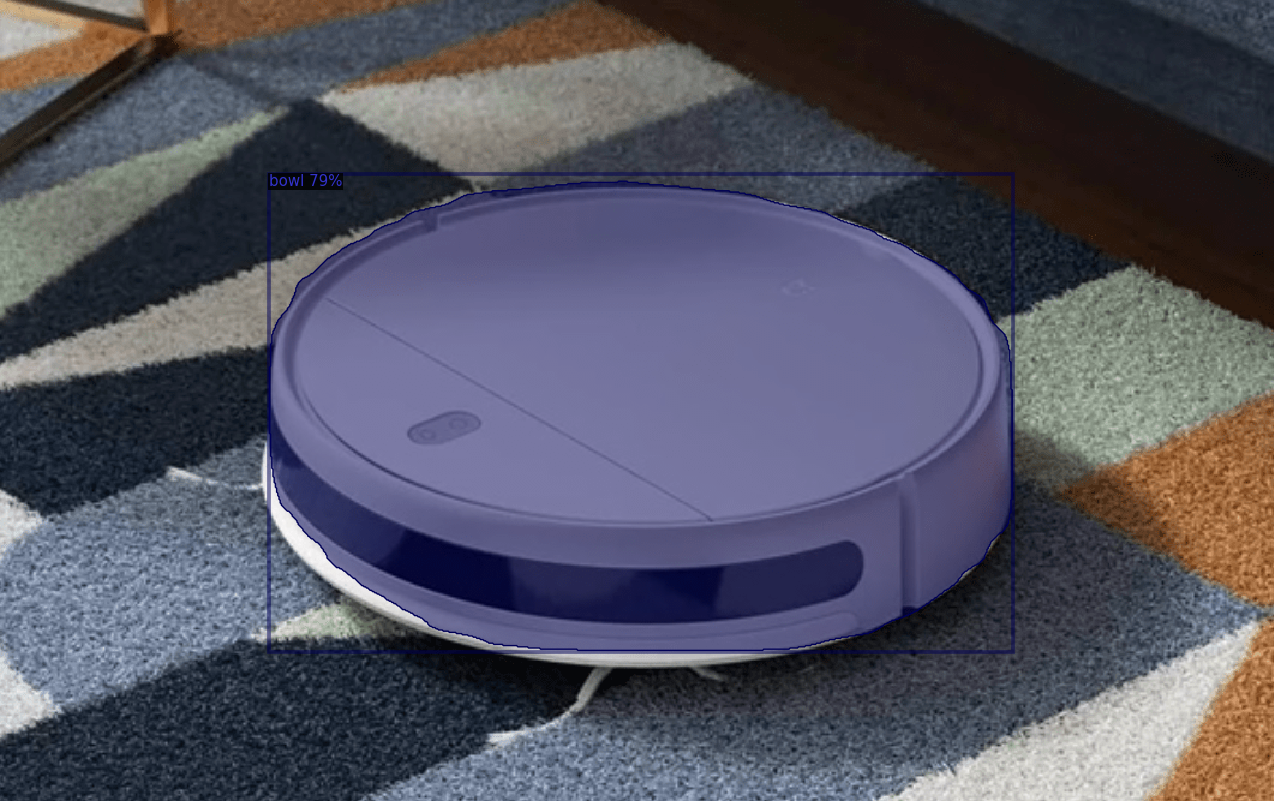

In [ ]:
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

Before: <class 'torch.Tensor'>
torch.Size([1, 668, 1062])
After: <class 'numpy.ndarray'>
(668, 1062)
(668, 1062)


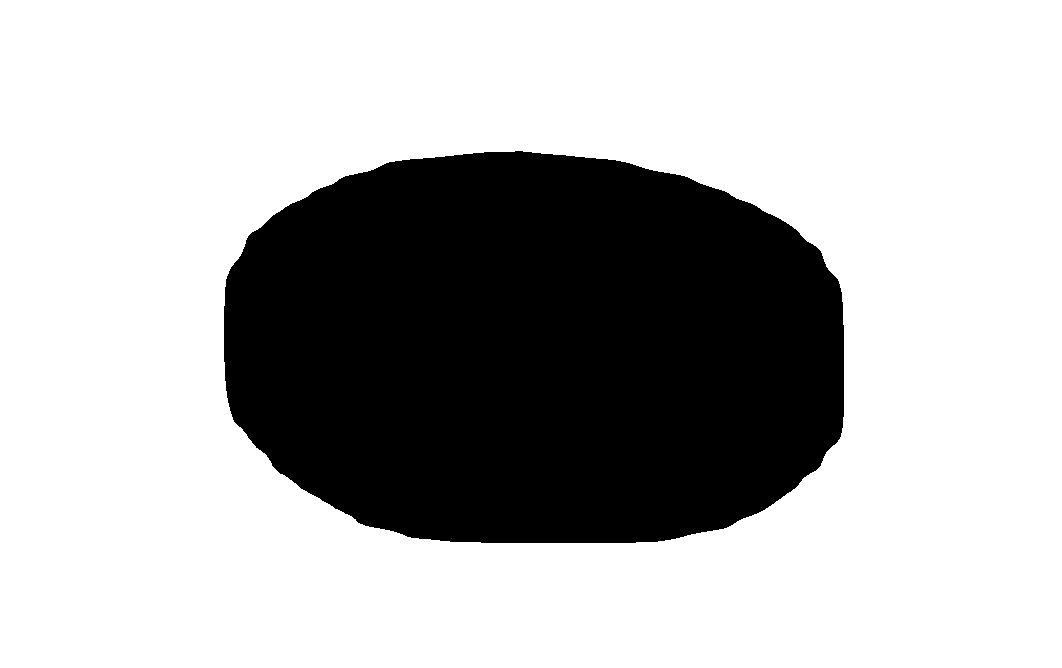

In [ ]:
item = outputs['instances'].pred_classes[0].item()
predictor.metadata.as_dict()["thing_classes"][item]
class_ids = np.array(outputs["instances"].pred_classes.cpu())
class_index = np.where(class_ids == item)
mask_tensor = outputs["instances"].pred_masks[class_index]

item_mask = mask_tensor.cpu()
print("Before:", type(item_mask))
print(item_mask.shape)
item_mask = np.array(item_mask[0])
print("After:", type(item_mask))
print(item_mask.shape)

background = np.zeros(item_mask.shape)
background.shape

bin_mask = cv2.bitwise_not(np.where(item_mask, 255, background).astype(np.uint8))
print(bin_mask.shape)
bin_mask
cv2_imshow(bin_mask)

  0%|          | 0/50 [00:00<?, ?it/s]

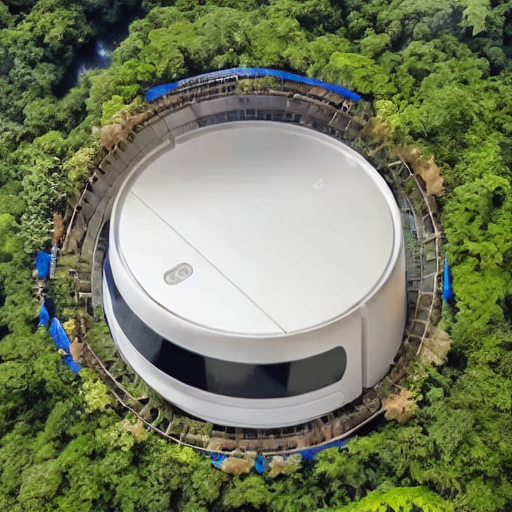

In [ ]:
from PIL import Image
im_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(im_img)

mask_img = cv2.cvtColor(bin_mask, cv2.COLOR_BGR2RGB)
mask_pil = Image.fromarray(mask_img)

prompt = "amazon jungle with river and sky"
new_image = pipeline(prompt=prompt, image=im_pil, mask_image=mask_pil).images[0]
new_image